## 1. Googlenet

#### 1.1. Import Libraries

In [55]:
import os
import gzip
import numpy as np
import urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import (ConcatDataset, DataLoader, Dataset, Subset,
                              random_split)
from torchvision import datasets, transforms

#### 1.2. Data Loading

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

combined_dataset = ConcatDataset([train_dataset, test_dataset])

#### 1.3. Split the dataset

In [57]:
train_size = 42000
val_size = 14000
test_size = 14000

# Split the combined dataset
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

In [58]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 42000
Validation size: 14000
Test size: 14000


#### 1.4. Custom Dataset for MNIST

This section of the code defines a custom dataset class for the MNIST dataset, enabling the integration of MNIST images into PyTorch's DataLoader for model training and evaluation.

In [59]:
# Define the custom dataset for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.stack([image] * 3, axis=-1)  # Convert to 3 channels for GoogLeNet

        # Convert the numpy array to a PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

#### 1.5. Data Transformations and Data Loaders

In this section, I defined the transformations to be applied to the MNIST dataset images and set up DataLoaders for efficient data handling during model training and evaluation.

In [60]:
# Define transformations and data loaders with explicit float conversion
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize across 3 channels
])

# Use the updated transform in the Dataset class
train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
val_dataset = MNISTDataset(val_images, val_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 1.6. Load the Googlenet model


In [61]:
# Load GoogLeNet model and set the final layer for 10 classes 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 1.7. Train model

In [62]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

In [63]:
# Train the model and record losses
num_epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Epoch [1/10], Train Loss: 0.1669, Val Loss: 0.0864
Epoch [2/10], Train Loss: 0.0644, Val Loss: 0.0637
Epoch [3/10], Train Loss: 0.0533, Val Loss: 0.0428
Epoch [4/10], Train Loss: 0.0337, Val Loss: 0.0377
Epoch [5/10], Train Loss: 0.0349, Val Loss: 0.0471
Epoch [6/10], Train Loss: 0.0332, Val Loss: 0.0473
Epoch [7/10], Train Loss: 0.0308, Val Loss: 0.0362
Epoch [8/10], Train Loss: 0.0217, Val Loss: 0.0715
Epoch [9/10], Train Loss: 0.0242, Val Loss: 0.0409
Epoch [10/10], Train Loss: 0.0218, Val Loss: 0.0444


In [64]:
import torch  # Import PyTorch
import pickle  # Import pickle for saving losses

# Save model state
model_path = "models/googlenet_mnist.pth"
torch.save(model.state_dict(), model_path)
print("Model saved!")

# Save training and validation losses
losses_path = "models/losses.pkl"
with open(losses_path, 'wb') as f:
    pickle.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)
print("Training and validation losses saved!")


Model saved!
Training and validation losses saved!


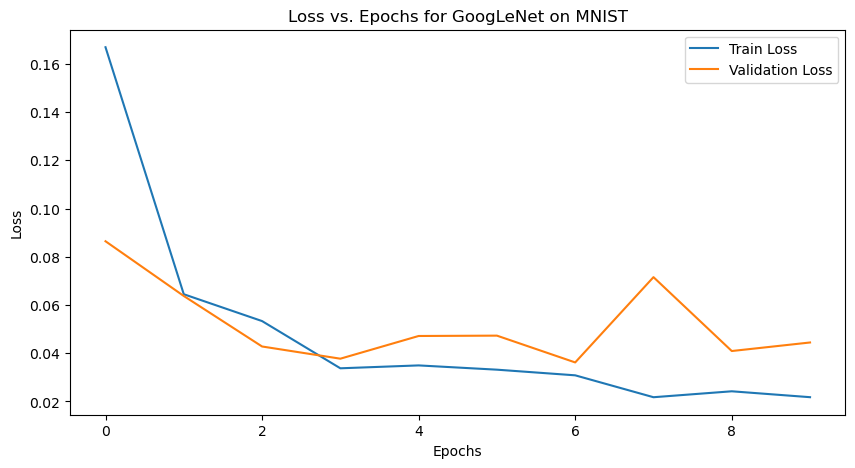

In [65]:
# Plot the loss vs. epochs graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs for GoogLeNet on MNIST")
plt.show()


In [66]:
import os  # Import the os module
import torch  # Import PyTorch
import pickle  # Import pickle for loading losses

model_path = "models/googlenet_mnist.pth"
losses_path = "models/losses.pkl"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk, skipping training.")

    if os.path.exists(losses_path):
        with open(losses_path, 'rb') as f:
            losses = pickle.load(f)
            train_losses = losses['train_losses']
            val_losses = losses['val_losses']
        print("Training and validation losses loaded from disk.")
    else:
        print("Losses file not found.")
else:
    print("Model file not found.")


Model loaded from disk, skipping training.
Training and validation losses loaded from disk.


C:\Users\Nimesh\AppData\Local\Temp\ipykernel_16280\751938757.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


#### 1.8. Test Data


In [67]:
from sklearn.metrics import accuracy_score


def evaluate(model, device, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(target.cpu().numpy())

    return accuracy_score(test_labels, test_preds)

# Evaluate the model and print test accuracy
test_accuracy = evaluate(model, device, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Test Accuracy: 99.04%


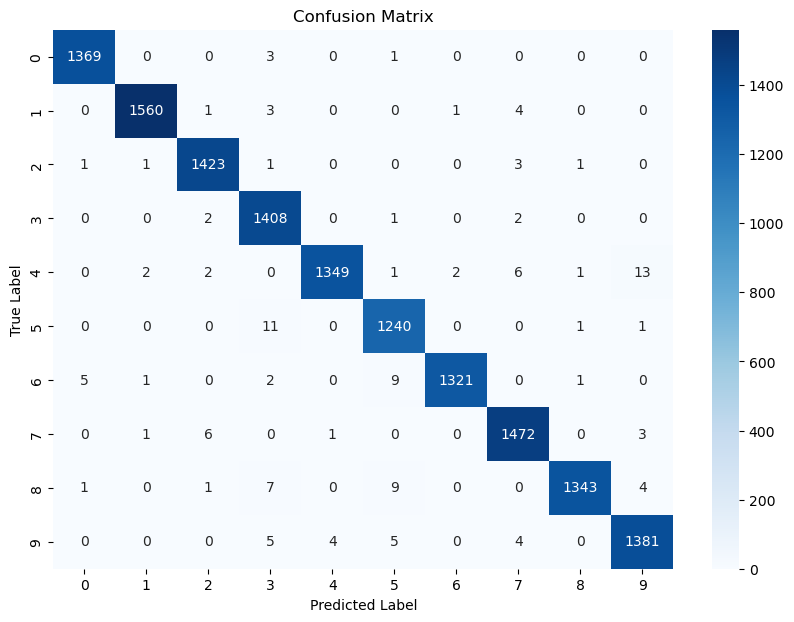

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions and true labels
all_preds = torch.tensor([])
all_labels = torch.tensor([])

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, predicted.cpu()), dim=0)
        all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()